How did you start Notebook
--------------------------

When starting this notebook using this:
```bash
~/tutorial-env/bin/ipython notebook --pylab=inline
```
comment out the code in the following cell.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


**Generate the data necessary to this project first.**

Generated input data is saved in: /tmp/tmpVqZ4WB


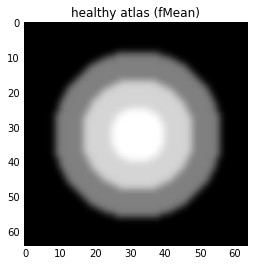

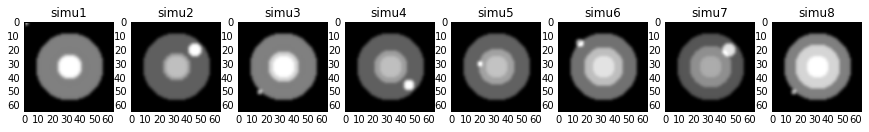

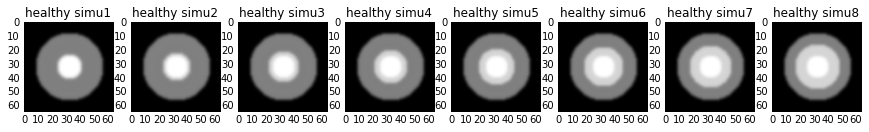

In [2]:
import tempfile
figure()
data_folder=tempfile.mkdtemp()
print "Generated input data is saved in: "+data_folder
%run ../../helper/gen_3D_simulation_data.py $data_folder

In [3]:
sys.path.append('../../')
from pyLAR import *
import shutil
import os

In [4]:
# global settings
result_folder = data_folder +'/try1_greedyDVF'
os.system('mkdir '+result_folder)
im_names = [ \
 data_folder+'/simu1.nrrd',
 data_folder+'/simu2.nrrd',
 data_folder+'/simu3.nrrd',
 data_folder+'/simu4.nrrd']
reference_im_name = data_folder +'/fMeanSimu.nrrd'

In [5]:
# data selection and global parameters, prepare iter0 data
selection = [0,1,2,3]    
num_of_data = len(selection)  
for i in range(num_of_data):
    iter0fn = result_folder+'/Iter0'+ '_simu_' + str(i)  + '.nrrd'
    simufn = im_names[selection[i]]
    shutil.copy(simufn, iter0fn)

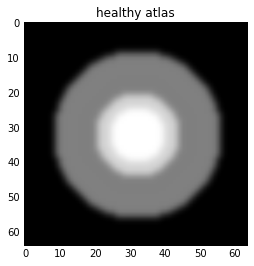

In [6]:
# profile data size, save into global variables
im_ref = sitk.ReadImage(reference_im_name) # image in SITK format
im_ref_array = sitk.GetArrayFromImage(im_ref) # get numpy array
z_dim, x_dim, y_dim = im_ref_array.shape # get 3D volume shape
vector_length = z_dim* x_dim*y_dim

implot = imshow(im_ref_array[32,:,:],cm.gray)
plt.title('healthy atlas')

slice_nr = 32  # just for vis purpose

**Configure software paths in cell below**

In [7]:
EXE_BRAINSDemonWarp = '/home/fbudin/Tools/Slicer-4.5.0-1-linux-amd64/Slicer --launch /home/fbudin/Tools/Slicer-4.5.0-1-linux-amd64/lib/Slicer-4.5/cli-modules/BRAINSDemonWarp'
EXE_ComposeMultiTransform = '/home/fbudin/Tools/ANTs.2.1.0.Debian-Ubuntu_X64/ComposeMultiTransform'
EXE_BRAINSResample = '/home/fbudin/Tools/Slicer-4.5.0-1-linux-amd64/Slicer --launch /home/fbudin/Tools/Slicer-4.5.0-1-linux-amd64/lib/Slicer-4.5/cli-modules/BRAINSResample'

In [8]:
###############################  the main pipeline #############################
def runIteration(currentIter,gridSize=[3,3,3]):
    # run RPCA
    Y = np.zeros((vector_length,num_of_data))
    for i in range(num_of_data) :
        im_file =  result_folder+'/'+ 'Iter'+str(currentIter - 1)+'_simu_' + str(i)  + '.nrrd'
        tmp = sitk.ReadImage(im_file)
        #print 'read:'+ im_file
        tmp = sitk.GetArrayFromImage(tmp)
        Y[:,i] = tmp.reshape(-1)
    
    low_rank, sparse, n_iter,rank, _,sparsity = rpca(Y,lamda)
    saveImagesFromDM(low_rank,result_folder+'/'+ 'Iter'+str(currentIter) +'_LowRank_', reference_im_name)
    saveImagesFromDM(sparse,result_folder+'/'+ 'Iter'+str(currentIter) +'_Sparse_', reference_im_name)
    
    # Visualize and inspect
    fig = plt.figure(figsize=(15,5))
    showSlice(Y, 'Iter'+str(currentIter) +' Input',cm.gray,0, reference_im_name)    
    showSlice(low_rank,'Iter'+str(currentIter) +' low rank',cm.gray,1, reference_im_name)
    showSlice(sparse,'Iter'+str(currentIter) +' sparse',cm.gray,2, reference_im_name)
    savefig(result_folder+'/'+'Iter'+ str(currentIter)+'.png')
    plt.close(fig)
   
    # visualize the difference image  lowrank - reference
    im_ref_vec  = im_ref_array.reshape(-1)
    plt.figure(figsize=(15,5))
    for i  in range(num_of_data):
        plt.subplot2grid((1,num_of_data),(0,i))
        a = np.array((low_rank[:,i]).reshape(-1) - im_ref_vec)
        im = a.reshape(z_dim,x_dim,y_dim)
        implot = plt.imshow(im[slice_nr,:,:],cm.gray)
        plt.axis('off')
        plt.title('Iter'+str(currentIter)+'_simu_'+str(i))  
    savefig(result_folder+'/'+'Differ_Lowrank_Iter'+str(currentIter)+'.png')
    plt.close(fig)
    
     # Register low-rank images to the reference (healthy) image, and update the input images to the next iteration
    
    for i in range(num_of_data):
        movingIm = result_folder+'/'+ 'Iter'+ str(currentIter)+'_LowRank_' + str(i)  +'.nrrd'
        outputIm = result_folder+'/'+ 'Iter'+ str(currentIter)+'_Deformed_LowRank' + str(i)  + '.nrrd'
        outputTransform = result_folder+'/'+ 'Iter'+ str(currentIter)+'_Transform_' + str(i) +  '.tfm'
        outputDVF = result_folder+'/'+ 'Iter'+ str(currentIter)+'_DVF_' + str(i) +  '.nrrd'
      
        outputComposedDVFIm = result_folder+'/'+ 'Iter'+ str(currentIter)+'_Composed_DVF_' + str(i) +  '.nrrd'
        newInputImage = result_folder+'/Iter'+ str(currentIter)+'_simu_' +str(i) +  '.nrrd'
        initialInputImage= result_folder+'/Iter0_simu_' +str(i) +  '.nrrd'
        
        logFile = open(result_folder+'/iteration'+ str(i)+'.log', 'w') 
   
        
        cmd = DemonsReg(EXE_BRAINSDemonWarp, reference_im_name,movingIm,outputIm, outputDVF)
        #cmd = BSplineReg(reference_im_name,movingIm,outputIm, outputTransform,gridSize)
        #cmd = cmd + ';' +ConvertTransform(reference_im_name,outputTransform,outputDVF)
       
        
        # compose deformations then apply to the original input image
        if COMPOSE_DVF is True:
            DVFImageList=[]
            for k in range(currentIter):
                DVFImageList.append(result_folder+'/'+ 'Iter'+ str(k+1)+'_DVF_' + str(i) +  '.nrrd')
            
            cmd = cmd + ';' + composeMultipleDVFs(EXE_ComposeMultiTransform, reference_im_name,DVFImageList,outputComposedDVFIm)
            cmd = cmd + ';' + updateInputImageWithDVF(EXE_BRAINSResample, initialInputImage,reference_im_name, \
                                                      outputComposedDVFIm,newInputImage)
         
            #cmd = cmd + ';' + WarpImageMultiDVF(initialInputImage,reference_im_name,DVFImageList,newInputImage)
          
        else:
            # update from previous Image
            previousInputImage = result_folder+'/Iter'+str(currentIter-1)+ '_simu_' + str(i)  + '.nrrd'
            cmd = cmd + ';' + updateInputImageWithDVF(EXE_BRAINSResample, previousInputImage,reference_im_name, outputDVF,newInputImage)
            
        
        process = subprocess.Popen(cmd, stdout = logFile, shell = True)
        process.wait()
        logFile.close()
        
    return sparsity
    

iter1
[iter: 0000]: rank(P) = 0001, |C|_0 = 92291, crit=0.2491075230, total sparse =823926
[iter: 0010]: rank(P) = 0001, |C|_0 = 36996, crit=0.0009093311, total sparse =263732
[iter: 0020]: rank(P) = 0001, |C|_0 = 64208, crit=0.0000317941, total sparse =264633
[iter: 0030]: rank(P) = 0001, |C|_0 = 116499, crit=0.0000003609, total sparse =264706
RPCA takes:2.667880 seconds
iter2
[iter: 0000]: rank(P) = 0001, |C|_0 = 45422, crit=0.1952656897, total sparse =1465539
[iter: 0010]: rank(P) = 0001, |C|_0 = 56245, crit=0.0014965009, total sparse =206912
[iter: 0020]: rank(P) = 0001, |C|_0 = 82927, crit=0.0000334669, total sparse =205379
[iter: 0030]: rank(P) = 0002, |C|_0 = 151354, crit=0.0000008195, total sparse =205307
RPCA takes:2.960267 seconds
iter3
[iter: 0000]: rank(P) = 0001, |C|_0 = 37993, crit=0.1660794941, total sparse =1129329
[iter: 0010]: rank(P) = 0001, |C|_0 = 40540, crit=0.0017454630, total sparse =192964
[iter: 0020]: rank(P) = 0002, |C|_0 = 71468, crit=0.0000366536, total sp

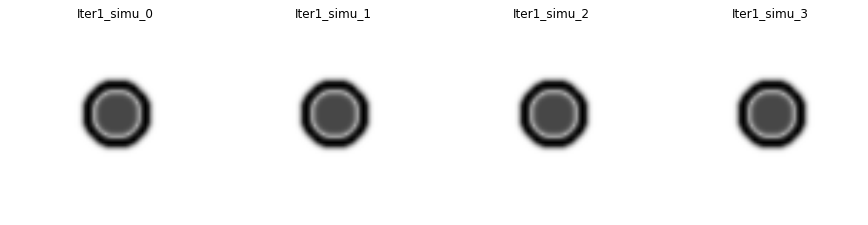

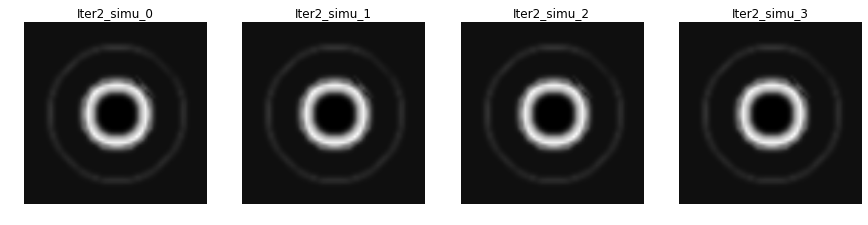

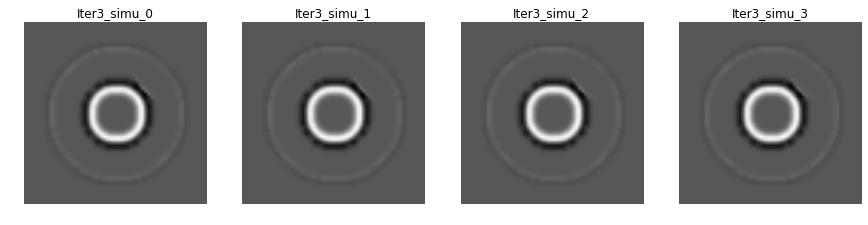

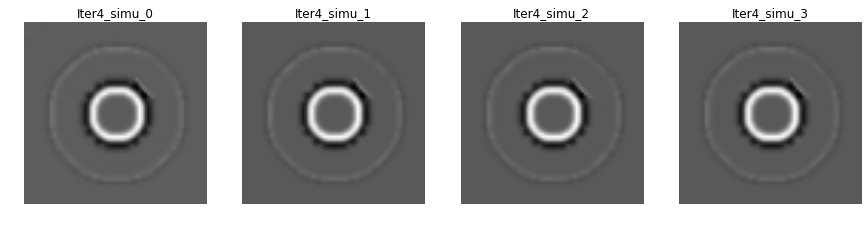

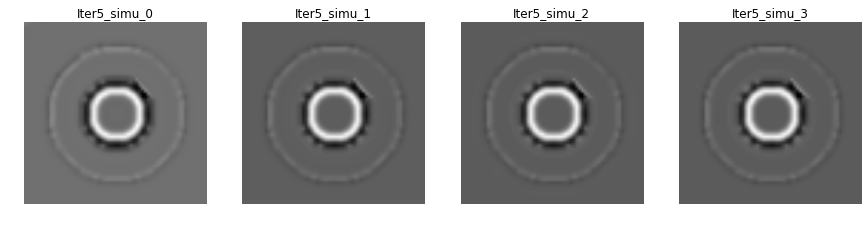

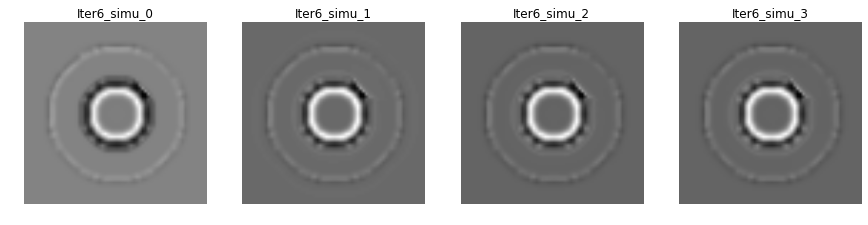

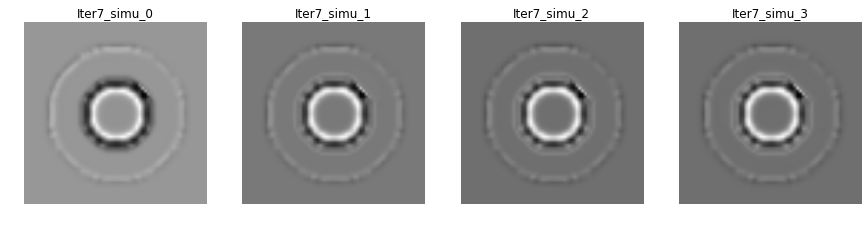

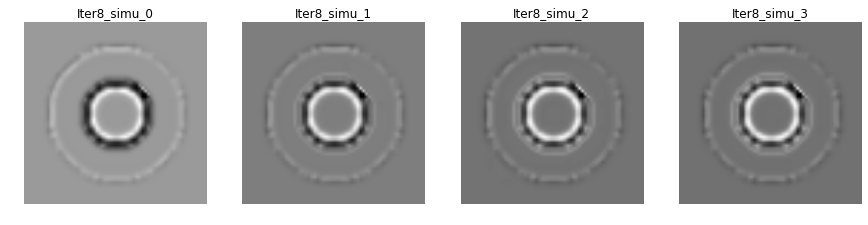

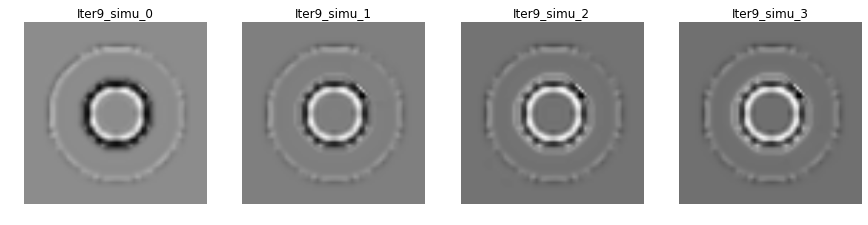

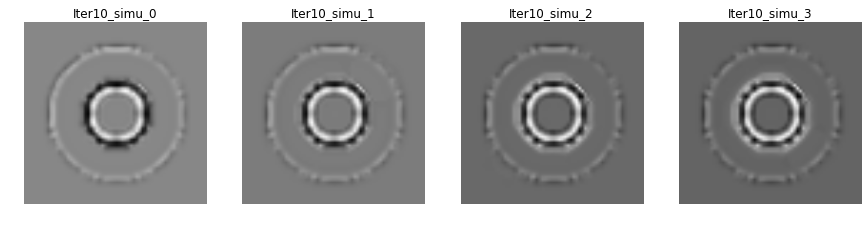

In [9]:
# main
NUM_OF_ITERATIONS = 10
lamda = 1.0
sparsity = zeros(NUM_OF_ITERATIONS)
COMPOSE_DVF = True
gridSize = [3,3,3]
for i in range(0,NUM_OF_ITERATIONS):
    print 'iter'+str(i+1)
    sparsity[i]= runIteration(i+1, gridSize)

    lamda = lamda +0.1
    gridSize[0] =gridSize[0] + 2
    gridSize[1] =gridSize[1] + 2
    gridSize[2] =gridSize[2] + 2

In [10]:
#visulaize DVFs
for i in range(num_of_data):
   for currentIter in range(1,NUM_OF_ITERATIONS):
        outputComposedDVFIm = result_folder+'/'+ 'Iter'+ str(currentIter)+'_DVF_' + str(i) +  '.nrrd'
        deformedInputIm = result_folder+'/'+ 'Iter'+ str(currentIter+1)+'_simu_' + str(i) +  '.nrrd'
        gridVisDVF(outputComposedDVFIm,32,'DVF_Vis_Simu'+str(i) +'_Iter'+str(currentIter+1),result_folder,deformedInputIm)
   

[ 264706.6989837   205307.82829459  197881.32042772  205792.15111796
  198714.65126408  181977.24752641  159151.60295219  136919.93849569
  117810.12781058  103949.35687042]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


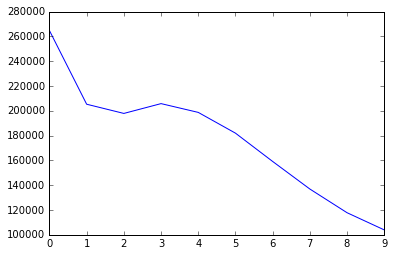

In [11]:
figure()
print sparsity
print range(NUM_OF_ITERATIONS)
plot(range(NUM_OF_ITERATIONS), sparsity)
savefig(result_folder+'/Sparsity.png')



In [12]:
def computeHealthyDeformations():
    #Validation & Comparison: register healthy simulation images to frechet mean
    healthyIm_names = [ \
     data_folder+'/healthySimu1.nrrd',
     data_folder+'/healthySimu2.nrrd',
     data_folder+'/healthySimu3.nrrd',
     data_folder+'/healthySimu4.nrrd']

    for i in range(num_of_data):
        fn = healthyIm_names[selection[i]]
        outputIm = data_folder+'/healthy/healthyDeformed_' + str(i)  + '.nrrd'
        outputDVF = data_folder+'/healthy/healthyDVF_' + str(i) +  '.nrrd'
    
        cmd = DemonsReg(reference_im_name,fn,outputIm, outputDVF)
    
        logFile = open(data_folder+'/healthy/healthy_'+ str(i)+'.log', 'w')

        process = subprocess.Popen(cmd, stdout = logFile, shell = True)
        process.wait()
        logFile.close()

#computeHealthyDeformations()

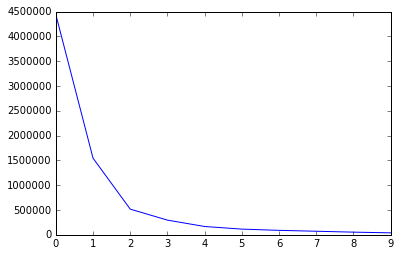

In [13]:
# check atlas similarities
# check atlas similarities

MSE = zeros((num_of_data, NUM_OF_ITERATIONS))
for i in range(NUM_OF_ITERATIONS):
    for j in range(num_of_data):
        lowrankIm = result_folder+'/'+ 'Iter'+str(i+1) +'_LowRank_' +str(j) + '.nrrd'
        im = sitk.ReadImage(lowrankIm) # image in SITK format
        im_array = sitk.GetArrayFromImage(im)
        MSE[j,i] = np.sum(np.square(im_ref_array - im_array))

    
figure()
plot(range(NUM_OF_ITERATIONS),sum(MSE,0) )
savefig(result_folder+'/MSE.png')